### Credit Risk analysis ###
https://www.kaggle.com/competitions/home-credit-default-risk ###


general points:
- for some reason, kernel keeps ram-crashing whenever I try to replace some values using .loc. have to downscale dataset.

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [11]:
time0 = time.time()

# for some reason i cannot properly read column description file... will have to open it locally

#ss = pd.read_csv('../input/home-credit-default-risk/sample_submission.csv')
#display(ss.head(), ss.shape)

df = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
df = df.sample(150000)
display(df.shape, df.head(), time.time()-time0, sys.getsizeof(df))

(150000, 122)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
15629,118236,0,Cash loans,F,N,Y,2,135000.0,1256400.0,36864.0,900000.0,Children,Working,Higher education,Single / not married,House / apartment,0.031329,-14812,-1283,-7015.0,-4248,NaN,1,1,1,1,0,0,Core staff,3.0,2,2,THURSDAY,11,0,0,0,0,0,0,School,0.808195,0.652710,0.600658,0.0619,0.0619,0.9896,0.8572,0.0553,0.0,0.1034,0.1667,0.2083,0.0280,0.0504,0.0668,0.0,0.0,0.0630,0.0642,0.9896,0.8628,0.0559,0.0,0.1034,0.1667,0.2083,0.0286,0.0551,0.0696,0.0,0.0,0.0625,0.0619,0.9896,0.8591,0.0557,0.0,0.1034,0.1667,0.2083,0.0284,0.0513,0.0680,0.0,0.0,reg oper account,block of flats,0.0828,"Stone, brick",No,1.0,0.0,1.0,0.0,-1146.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
14557,116983,1,Cash loans,M,Y,Y,0,180000.0,540000.0,14980.5,540000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.015221,-10420,-408,-6987.0,-2448,6.0,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,11,0,1,1,0,1,1,Construction,NaN,0.122730,0.132597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
107365,224566,0,Cash loans,M,N,Y,0,157500.0,607500.0,22644.0,607500.0,Unaccompanied,Working,Higher education,Single / not married,House / apartment,0.028663,-15382,-617,-6885.0,-3714,NaN,1,1,0,1,1,0,Core staff,1.0,2,2,TUESDAY,11,0,0,0,0,1,1,Business Entity Type 2,0.503128,0.646759,0.577969,0.0175,NaN,0.9767,NaN,NaN,NaN,0.0690,0.0417,NaN,NaN,NaN,0.0146,NaN,NaN,0.0179,NaN,0.9767,NaN,NaN,NaN,0.0690,0.0417,NaN,NaN,NaN,0.0152,NaN,NaN,0.0177,NaN,0.9767,NaN,NaN,NaN,0.0690,0.0417,NaN,NaN,NaN,0.0149,NaN,NaN,NaN,block of flats,0.0122,Panel,No,0.0,0.0,0.0,0.0,-3359.0,0,1,

5.580460071563721

275746032

In [12]:
df.columns = [col.lower() for col in list(df.columns)]
display(df.head(), df.target.mean())

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
15629,118236,0,Cash loans,F,N,Y,2,135000.0,1256400.0,36864.0,900000.0,Children,Working,Higher education,Single / not married,House / apartment,0.031329,-14812,-1283,-7015.0,-4248,NaN,1,1,1,1,0,0,Core staff,3.0,2,2,THURSDAY,11,0,0,0,0,0,0,School,0.808195,0.652710,0.600658,0.0619,0.0619,0.9896,0.8572,0.0553,0.0,0.1034,0.1667,0.2083,0.0280,0.0504,0.0668,0.0,0.0,0.0630,0.0642,0.9896,0.8628,0.0559,0.0,0.1034,0.1667,0.2083,0.0286,0.0551,0.0696,0.0,0.0,0.0625,0.0619,0.9896,0.8591,0.0557,0.0,0.1034,0.1667,0.2083,0.0284,0.0513,0.0680,0.0,0.0,reg oper account,block of flats,0.0828,"Stone, brick",No,1.0,0.0,1.0,0.0,-1146.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
14557,116983,1,Cash loans,M,Y,Y,0,180000.0,540000.0,14980.5,540000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.015221,-10420,-408,-6987.0,-2448,6.0,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,11,0,1,1,0,1,1,Construction,NaN,0.122730,0.132597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
107365,224566,0,Cash loans,M,N,Y,0,157500.0,607500.0,22644.0,607500.0,Unaccompanied,Working,Higher education,Single / not married,House / apartment,0.028663,-15382,-617,-6885.0,-3714,NaN,1,1,0,1,1,0,Core staff,1.0,2,2,TUESDAY,11,0,0,0,0,1,1,Business Entity Type 2,0.503128,0.646759,0.577969,0.0175,NaN,0.9767,NaN,NaN,NaN,0.0690,0.0417,NaN,NaN,NaN,0.0146,NaN,NaN,0.0179,NaN,0.9767,NaN,NaN,NaN,0.0690,0.0417,NaN,NaN,NaN,0.0152,NaN,NaN,0.0177,NaN,0.9767,NaN,NaN,NaN,0.0690,0.0417,NaN,NaN,NaN,0.0149,NaN,NaN,NaN,block of flats,0.0122,Panel,No,0.0,0.0,0.0,0.0,-3359.0,0,1,

0.07999333333333333

In [13]:
# I will process features in batches and will keep adding them as i go along
# I want to run EDA first to understand what those features are 

num_features = ['cnt_children', 'amt_income_total', 'amt_credit', 'amt_annuity', 'amt_goods_price', 
               'region_population_relative', 'days_birth', 'days_employed', 'days_registration', 'days_id_publish', 
               'own_car_age', 'cnt_fam_members', 'ext_source_1', 'ext_source_2', 'ext_source_3']
cat_features = ['name_contract_type', 'code_gender', 'flag_own_car', 'flag_own_realty', 'name_type_suite', 
               'name_income_type', 'name_education_type', 'name_family_status', 'name_housing_type', 'occupation_type']
bin_features = ['flag_mobil', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email']

df = df[['sk_id_curr', 'target']+num_features+cat_features+bin_features]
gc.collect()
display(df.shape, df.head(), df.info(), sys.getsizeof(df))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 15629 to 22495
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   sk_id_curr                  150000 non-null  int64  
 1   target                      150000 non-null  int64  
 2   cnt_children                150000 non-null  int64  
 3   amt_income_total            150000 non-null  float64
 4   amt_credit                  150000 non-null  float64
 5   amt_annuity                 149995 non-null  float64
 6   amt_goods_price             149869 non-null  float64
 7   region_population_relative  150000 non-null  float64
 8   days_birth                  150000 non-null  int64  
 9   days_employed               150000 non-null  int64  
 10  days_registration           150000 non-null  float64
 11  days_id_publish             150000 non-null  int64  
 12  own_car_age                 50918 non-null   float64
 13  cnt_fam_mem

(150000, 33)

,sk_id_curr,target,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,cnt_fam_members,ext_source_1,ext_source_2,ext_source_3,name_contract_type,code_gender,flag_own_car,flag_own_realty,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,occupation_type,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email
15629,118236,0,2,135000.0,1256400.0,36864.0,900000.0,0.031329,-14812,-1283,-7015.0,-4248,NaN,3.0,0.808195,0.652710,0.600658,Cash loans,F,N,Y,Children,Working,Higher education,Single / not married,House / apartment,Core staff,1,1,1,1,0,0
14557,116983,1,0,180000.0,540000.0,14980.5,540000.0,0.015221,-10420,-408,-6987.0,-2448,6.0,2.0,NaN,0.122730,0.132597,Cash loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,1,1,0,1,0,0
107365,224566,0,0,157500.0,607500.0,22644.0,607500.0,0.028663,-15382,-617,-6885.0,-3714,NaN,1.0,0.503128,0.646759,0.577969,Cash loans,M,N,Y,Unaccompanied,Working,Higher education,Single / not married,House / apartment,Core staff,1,1,0,1,1,0
28598,133235,0,0,270000.0,787500.0,29313.0,787500.0,0.028663,-17789,-3270,-1303.0,-1314,NaN,2.0,NaN,0.701030,0.468660,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,NaN,1,1,0,1,0,0
22799,126530,0,0,225000.0,785398.5,33403.5,702000.0,0.019689,-18042,-1569,-7272.0,-1569,6.0,2.0,NaN,0.530077,0.771362,Cash loans,F,Y,N,Family,Commercial associate,Secondary / secondary special,Married,House / apartment,Sales staff,1,1,0,1,0,0


None

127401303

In [14]:
# some basic cleaning

df.code_gender = (df.code_gender=='M').astype(int)
df.flag_own_car = (df.flag_own_car=='Y').astype(int)
display(sys.getsizeof(df))




112401303

In [20]:
dftypes = df.dtypes
o_features = list((dftypes[dftypes=='O']).index)
for col in o_features:
    df[col] = df[col].astype('category')
display(df.dtypes, sys.getsizeof(df), df.head())

sk_id_curr                       int64
target                           int64
cnt_children                     int64
amt_income_total               float64
amt_credit                     float64
amt_annuity                    float64
amt_goods_price                float64
region_population_relative     float64
days_birth                       int64
days_employed                    int64
days_registration              float64
days_id_publish                  int64
own_car_age                    float64
cnt_fam_members                float64
ext_source_1                   float64
ext_source_2                   float64
ext_source_3                   float64
name_contract_type            category
code_gender                      int64
flag_own_car                     int64
flag_own_realty               category
name_type_suite               category
name_income_type              category
name_education_type           category
name_family_status            category
name_housing_type        

32405667

,sk_id_curr,target,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,cnt_fam_members,ext_source_1,ext_source_2,ext_source_3,name_contract_type,code_gender,flag_own_car,flag_own_realty,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,occupation_type,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email
15629,118236,0,2,135000.0,1256400.0,36864.0,900000.0,0.031329,-14812,-1283,-7015.0,-4248,NaN,3.0,0.808195,0.652710,0.600658,Cash loans,0,0,Y,Children,Working,Higher education,Single / not married,House / apartment,Core staff,1,1,1,1,0,0
14557,116983,1,0,180000.0,540000.0,14980.5,540000.0,0.015221,-10420,-408,-6987.0,-2448,6.0,2.0,NaN,0.122730,0.132597,Cash loans,1,1,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,1,1,0,1,0,0
107365,224566,0,0,157500.0,607500.0,22644.0,607500.0,0.028663,-15382,-617,-6885.0,-3714,NaN,1.0,0.503128,0.646759,0.577969,Cash loans,1,0,Y,Unaccompanied,Working,Higher education,Single / not married,House / apartment,Core staff,1,1,0,1,1,0
28598,133235,0,0,270000.0,787500.0,29313.0,787500.0,0.028663,-17789,-3270,-1303.0,-1314,NaN,2.0,NaN,0.701030,0.468660,Cash loans,0,0,Y,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,NaN,1,1,0,1,0,0
22799,126530,0,0,225000.0,785398.5,33403.5,702000.0,0.019689,-18042,-1569,-7272.0,-1569,6.0,2.0,NaN,0.530077,0.771362,Cash loans,0,1,N,Family,Commercial associate,Secondary / secondary special,Married,House / apartment,Sales staff,1,1,0,1,0,0


### EDA 

EDA.1. What do people take loans for? Car purchases? Lets explore loan amounts. Probably this is outside of the US, so it is hard to tell what the price scale is...

,amt_credit,amt_goods_price
count,1.500000e+05,1.498800e+05
mean,5.991576e+05,5.384881e+05
std,4.028970e+05,3.699451e+05
min,4.500000e+04,4.500000e+04
25%,2.700000e+05,2.385000e+05
50%,5.147775e+05,4.500000e+05
75%,8.086500e+05,6.795000e+05
max,4.050000e+06,4.050000e+06


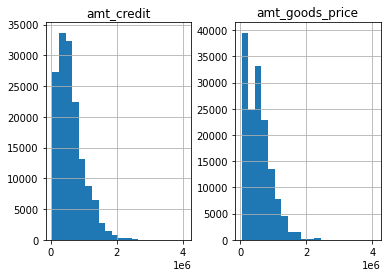

In [6]:
display(df[['amt_credit', 'amt_goods_price']].describe())
df[['amt_credit', 'amt_goods_price']].hist(bins=20)
df['goods_to_loan'] = df.amt_goods_price/df.amt_credit

With the minimum good price of 40,000, vast majority o the loans must be for home purchase.

## EDA.2. Can people afford the loan given their income?

count    150000.000000
mean          3.953762
std           2.684636
min           0.037500
25%           2.005800
50%           3.259180
75%           5.153846
max          49.227200
Name: dti, dtype: float64

<AxesSubplot:>

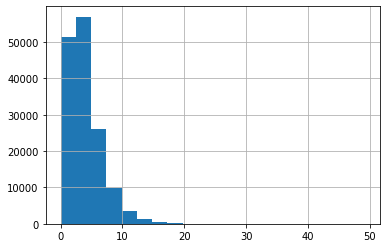

count    149993.000000
mean          0.053719
std           0.022524
min           0.022073
25%           0.036900
50%           0.050000
75%           0.064055
max           0.124430
Name: malr, dtype: float64

<AxesSubplot:>

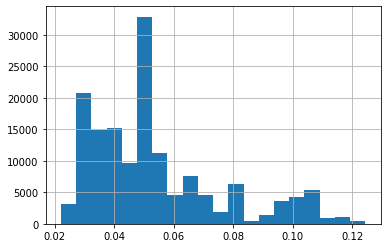

In [7]:
# lets compute debt to income ratio

df['dti'] = df.amt_credit/df.amt_income_total
display(df.dti.describe(), df.dti.hist(bins=20))
plt.show()

#sns.barplot(y='dti', x='target', data=df)
#plt.show()
# no clear pattern. we would expect this, otherwise lending behavior of a lender would be unwise.

df['malr'] = df.amt_annuity/df.amt_credit
display(df.malr.describe(), df.malr.hist(bins=20))

# this company seems to be lending aggressively: average loan will probably be repayed in 2-4 years, 
# while loan amount is usually above total income.

count    150000.000000
mean      63998.333833
std      141433.176440
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -287.750000
max      365243.000000
Name: days_employed, dtype: float64

16117

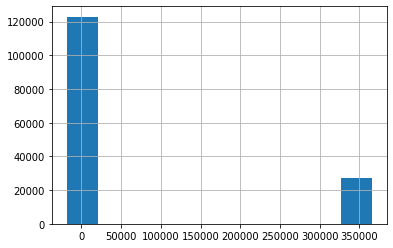

In [8]:
display(df.days_employed.describe())
df.days_employed.hist()
gc.collect()

In [ ]:
# transform days features to be more intuitive:

df['years_birth'] = -df['days_birth']/365
df['years_employed'] = -df['days_employed']/365
df.loc[df.years_employed<0, df.years_employed]=-1
df['years_registration'] = -df['days_registration']/365
df['years_id_publish'] = -df['days_id_publish']/365

display(df[['years_birth', 'years_employed', 'years_registration', 'years_id_publish']].describe())
df.drop(columns = ['days_birth', 'days_employed', 'days_registration', 'days_id_publish'], inplace=True)
gc.collect()

In [ ]:
display(df.own_car_age.describe())
# i guess missing values are mix of ppl without a car and ppl who did not provide any info on their car
# if i had a good car, i would give this info to a loan agency to decrease my interest rate
# so i guess those are either crappy cars or no cars
# I encode them as 30-years old cars
df.loc[df.own_car_age.isnull(), df.own_car_age]=30
display(df.own_car_age.describe())